In [1]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [2]:
%autosave 0
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
from matplotlib import animation
from functools import partial
slider_layout = widgets.Layout(width='600px', height='20px')
slider_style = {'description_width': 'initial'}
IntSlider_nice = partial(widgets.IntSlider, style=slider_style, layout=slider_layout, continuous_update=False)
FloatSlider_nice = partial(widgets.FloatSlider, style=slider_style, layout=slider_layout, continuous_update=False)
SelSlider_nice = partial(widgets.SelectionSlider, style=slider_style, layout=slider_layout, continuous_update=False)

Autosave disabled


# Material teórico

[Slides](https://docs.google.com/presentation/d/1IJ2n8X4w8pvzNLmpJB-ms6-GDHWthfsJTFuyUqHfXg8/edit?usp=sharing)

# Breve tutorial de [PyTorch](https://pytorch.org) 

PyTorch es una librería de alto nivel para Python que provee 
1. Una clase tensor para hacer cómputo de alto rendimiento 
1. Un plataforma para crear y entrenar redes neuronales

### Torch Tensor

La clase [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html) es muy similar en uso al `ndarray` de [*NumPy*](https://numpy.org/)

Un tensor corresponde a una matriz o arreglo n-dimensional con tipo definido que soporta operaciónes vectoriales tipo SIMD y broadcasting


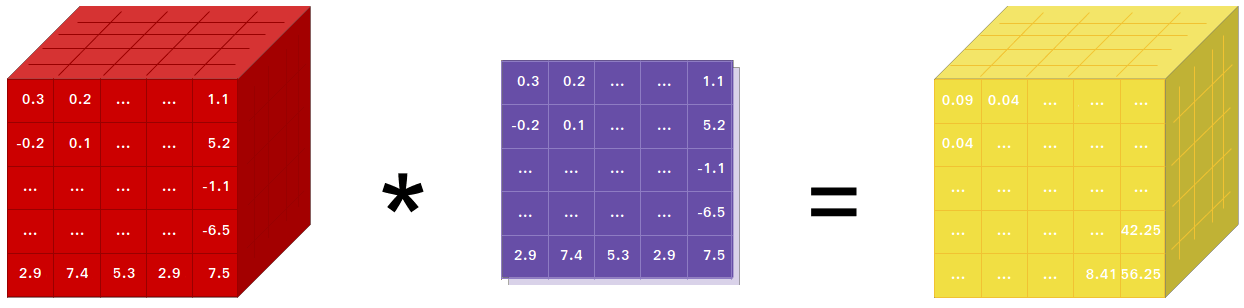

La documentación de la clase con todas las operaciones que soporta: https://pytorch.org/docs/stable/tensors.html

A continuación revisaremos las más fundamentales

In [3]:
import torch
torch.__version__

'1.0.1'

#### Creación de tensores

Un tensor puede crearse usando constructores de torch o a partir de datos existentes: lista de Python o *ndarray* de NumPy

In [ ]:
# Un tensor de 10 ceros
display(torch.zeros(10))
# Un tensor de 10 unos
display(torch.ones(10))
# Un tensor de números linealmente espaciados
display(torch.linspace(0, 9, steps=10))
# Un tensor de 10 números aleatorios con distribución N(0, 1)
display(torch.randn(10))
# Un tensor creado a partir de una lista
display(torch.Tensor([0, 1, 2, 3, 4, 5, 6]))
# Un tensor creado a partir de un ndarray
numpy_array = np.random.randn(10)
display(torch.from_numpy(numpy_array))

#### Atributos importantes de los tensores

Un tensor tiene un tamaño (dimesiones) y tipo específico

Un tensor puede estar alojado en la memoria del sistema ('cpu') o en la memoria de dispositivo ('gpu')

In [ ]:
a = torch.randn(10, 20, 30)
display(a.shape)
display(a.dtype)
display(a.device)
display(a.requires_grad)

Cuando se crea un tensor se puede especificar el tipo y el dispositivo

In [ ]:
a = torch.zeros(10, dtype=torch.int32, device='cuda')
display(a)

#### Manipulación de tensores

Podemos manipular la forma de un tensor usando: reshape, flatten, roll, traspose, unsqueeze, entre otros

In [ ]:
a = torch.linspace(0, 9, 10)
display(a)
display(a.reshape(2, 5))
display(a.reshape(2, 5).t())
display(a.reshape(2, 5).flatten())
display(a.roll(2))
display(a.unsqueeze(1))

#### Cálculos con tensores

Un tensor soporta operaciones aritméticas y lógicas

Si el tensor está en memoria de sistema entonces las operaciones son realizadas por la CPU 

In [ ]:
a = torch.linspace(0, 5, steps=6)
display(a)
# aritmética y funciones
display(a + 5)
display(2*a)
display(a.pow(2))
display(a.log())
# máscaras booleanas
display(a[a>3])
# Operaciones con otros tensores
b = torch.ones(6)
display(a + b)
display(a*b)
# broadcasting
display(a.unsqueeze(1)*b.unsqueeze(0))

#### Cálculos en GPU

Usando el atributo `to` podemos intercambiar un tensor entre GPU ('device') y CPU ('host')

Cuando todos los tensores involucrados en una operaciones están en memoria de dispositivo entonces el cálculo lo hace la GPU

La siguiente nota indica las opciones para intercambiar datos entre GPU y CPU que ofrece PyTorch: https://pytorch.org/docs/stable/notes/cuda.html 

##### Breve nota: 
Una *Graphical Processing Unit* (GPU) o tarjeta de video es un hardware para hacer cálculos sobre mallas tridimensionales, generación de imágenes (rendering) y otras tareas gráficas. A diferencia de la CPU, la GPU es especialista en cálculo paralelo y tiene miles de nucleos (NVIDIA RTX 2080: 2944 nucleos)

In [ ]:
a = torch.zeros(10)
display(a.device)
a = a.to('cuda')
display(a.device)

### Auto-diferenciación

Las redes neuronales se entrenan usando **Gradiente descedente**

> Necesitamos calcular las derivadas de la función de costo para todos los parámetros de la red

Esto puede ser complejo si nuestra red es grande y tiene distintos tipos de capas

PyTorch viene incorporado con un sistema de diferenciación automática denominado [`autograd`](https://pytorch.org/docs/stable/autograd.html) 

Para poder derivar una función en pytorch

1. Se necesita que su entrada sean tensores con el atributo `requires_grad=True`
1. Luego llamamos la función `backward()` de la función
1. El resultado queda guardado en el atributo `grad` de la entrada (nodo hoja)

In [ ]:
x = torch.linspace(0, 10, steps=1000, requires_grad=True)

y = 5*x -20
#y = torch.sin(2.0*np.pi*x)
#y = torch.sin(2.0*np.pi*x)*torch.exp(-(x-5).pow(2)/3)

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x.detach().numpy(), y.detach().numpy(), label='y')

y.backward(torch.ones_like(x))

ax.plot(x.detach().numpy(), x.grad.detach().numpy(), label='dy/dx')
plt.legend();

### Grafo de cómputo

Cuando contatenamos operaciones PyTorch construye internamente un "grafo de cómputo"

$$
x \to z = f_1(x) \to y = f_2(z)
$$

La función `backward` calcula los gradientes y los almacena en los nodo hoja que tengan `requires_grad=True`

Por ejemplo

    y.backward : Guarda dy/dx en x.grad
    
    z.backward : Guarda dz/dx en x.grad

Basicamente `backward` implementa la regla de la cadena de las derivadas

`backward` recibe una entrada: La derivada de la etapa superior de la cadena. Por defecto usa `torch.ones([1])`, asume que se está en el nivel superior y que la salida es escalar (unidimensional)

In [ ]:
x = torch.linspace(0, 10, steps=1000, requires_grad=True) # Nodo hoja
display(x.grad_fn)
z = torch.sin(x)
display(z.grad_fn)
y = z.pow(2)
display(y.grad_fn)

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x.detach().numpy(), z.detach().numpy(), label='z')
ax.plot(x.detach().numpy(), y.detach().numpy(), label='y')
# Derivada dy/dx
y.backward(torch.ones_like(x), create_graph=True)
ax.plot(x.detach().numpy(), x.grad.detach().numpy(), label='dy/dx')
# Borro el resultado en x.grad
x.grad = None
# Derivada dz/dx
z.backward(torch.ones_like(x))
ax.plot(x.detach().numpy(), x.grad.detach().numpy(), label='dz/dx')
plt.legend();
#ax.plot(x.detach().numpy(), 2*np.cos(x.detach().numpy())*np.sin(x.detach().numpy()), label='dy/dx')

#  Redes Neuronales Artificiales en PyTorch

PyTorch nos ofrece la clase tensor y las funcionalidades de autograd

Estas poderosas herramientas nos dan todo lo necesario para construir y entrenar redes neuronales artificiales

Para facilitar aun más estas tareas PyTorch tiene módulos de alto nivel que implementan

1. Modelo base de red neuronal: `torch.nn.Module`
1. Distintos tipos de capas, funciones de activación y funciones de costo: [`torch.nn`](https://pytorch.org/docs/stable/nn.html)
1. Distintos algoritmos de optimización basados en gradiente descedente: [`torch.optim`](https://pytorch.org/docs/stable/optim.html)


Una red neuronal en PyTorch se implementa
1. Heredando de [`torch.nn.Module`](https://pytorch.org/docs/stable/nn.html#module)
1. Especificando las funciones `__init__` y `forward`

Otra opción es usar [`torch.nn.Sequential`](https://pytorch.org/docs/stable/nn.html#sequential) y especificar una lista de capas


#### Red MLP en pytorch:

Heredamos de `Module` y especificamos el constructor y la función `forward`

Creamos una red de dos entradas, una capa oculta y una neurona salida

La capa `torch.nn.Linear` con parámetro $W$ y $b$ realiza la siguiente operación sobre la entrada $X$

$$
Z = WX + b
$$

corresponde a la capa completamente conectada (*fully-connected*)

In [5]:
import torch

class MLP(torch.nn.Module):

    # Constructor: Crea las capas de la red
    def __init__(self, input_dim=2, hidden_dim=10, output_dim=1): 
        # Mandatorio: Llamar al constructor del padre:
        super(MLP, self).__init__()  
        # Creamos dos capas completamente conectadas
        self.hidden = torch.nn.Linear(input_dim, hidden_dim, bias=True)
        self.output = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        #input_dim número de neuronas de entrada de la primera capa
        #hidden_dim número de neuronas de salida de la primera capa y salida de la segunda capa
        #output_dim es la única neurona de salida del modelo
        #bias es para usar el b de la función
        # Función de activación sigmoide
        self.activation = torch.nn.Sigmoid()
        
    # Forward: Conecta la entrada con la salida
    def forward(self, x):
        # Pasamos x por la primera capa y luego aplicamos función de activación
        z = self.activation(self.hidden(x))
        # Pasamos el resultado por la segunda capa y lo retornamos
        return self.activation(self.output(z))
    

Al crear una capa `Linear` de forma interna se registran los parámetros `weight` y `bias`, ambos con `requires_grad=True`

Inicialmente los parámetros tienen valores aleatorios

In [6]:
model = MLP(hidden_dim=2)
display(model.hidden.weight) # W
display(model.hidden.bias) # b

Parameter containing:
tensor([[-0.2123,  0.2396],
        [ 0.3563, -0.5268]], requires_grad=True)

Parameter containing:
tensor([-0.4207,  0.0268], requires_grad=True)

Podemos evaluar el modelo sobre un tensor 

<IPython.core.display.Javascript object>


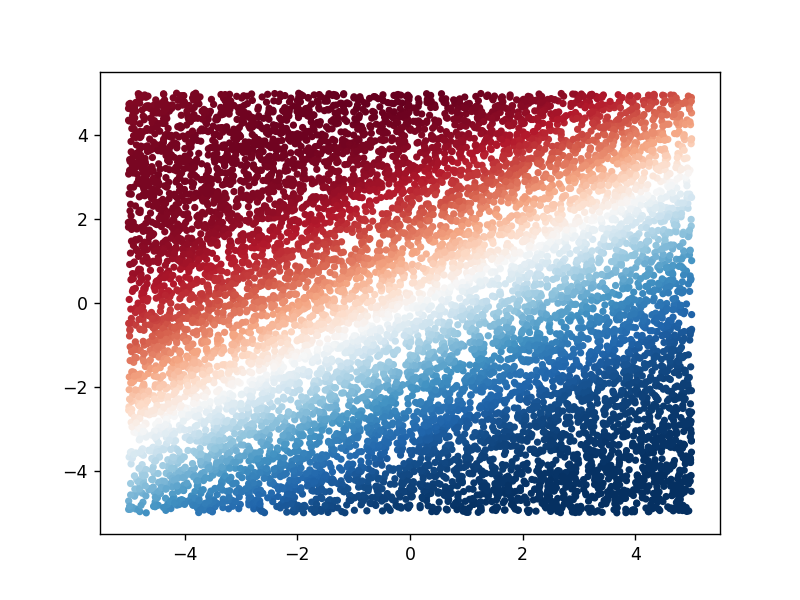

In [7]:
X = 10*torch.rand(10000, 2) - 5
Y = model.forward(X)

fig, ax = plt.subplots()
X_numpy = X.detach().numpy()
Y_numpy = Y.detach().numpy()
ax.scatter(X_numpy[:, 0], X_numpy[:, 1], s=10, c=Y_numpy[:, 0], cmap=plt.cm.RdBu_r);

### Entrenamiento

Para entrenar la neurona debemos definir 

- Una función de costo
- Un algoritmo de optimización

In [8]:
# Función de costo entropía cruzada binaria
criterion = torch.nn.BCELoss(reduction='sum')
# Algoritmo de optimización Gradiente Descendente Estocástico
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

Digamos que tenemos un dato $X$ y una etiqueta $Y$

Podemos calcular el error de clasificar ese dato con

In [9]:
X = torch.tensor([[-1.0, 1.0]])
Y = torch.tensor([[0.]])

hatY = model.forward(X)
display(hatY)
loss = criterion(hatY, Y)
display(loss)

tensor([[0.4326]], grad_fn=<SigmoidBackward>)

tensor(0.5667, grad_fn=<BinaryCrossEntropyBackward>)

Una vez que calculamos la loss podemos calcular el gradiente

In [10]:
loss.backward()
display(model.output.weight.grad)
display(model.output.bias.grad)

tensor([[0.2197, 0.1290]])

tensor([0.4326])

Finalmente actualizamos los parámetros usando la función `step` de nuestro optimizador

In [11]:
# Resetea los gradientes
display(model.output.weight)
display(model.output.bias)
optimizer.step()
display(model.output.weight)
display(model.output.bias)

Parameter containing:
tensor([[-0.3124, -0.6866]], requires_grad=True)

Parameter containing:
tensor([0.0920], requires_grad=True)

Parameter containing:
tensor([[-0.3146, -0.6879]], requires_grad=True)

Parameter containing:
tensor([0.0877], requires_grad=True)

Repetimos este proceso a través de varias "épocas" de entrenamiento

In [12]:
for nepoch in range(10):
    # Calculamos la salida del modelo
    hatY = model.forward(X)
    # Reseteamos los gradientes de la iteración anterior
    optimizer.zero_grad()
    # Calculamos la función de costo
    loss = criterion(hatY, Y)
    # Calculamos su gradiente
    loss.backward()
    # Actualizamos los parámetros
    optimizer.step()
    print("%d w:%f %f b:%f" %(nepoch, model.output.weight[0, 0], model.output.weight[0, 1], model.output.bias))

0 w:-0.316767 -0.689193 b:0.083397
1 w:-0.318950 -0.690477 b:0.079101
2 w:-0.321127 -0.691758 b:0.074821
3 w:-0.323298 -0.693036 b:0.070555
4 w:-0.325462 -0.694312 b:0.066304
5 w:-0.327619 -0.695584 b:0.062068
6 w:-0.329770 -0.696854 b:0.057847
7 w:-0.331915 -0.698121 b:0.053641
8 w:-0.334053 -0.699385 b:0.049449
9 w:-0.336185 -0.700647 b:0.045273


#### Entrenando en un conjunto de datos

Consideremos un conjunto de entrenamiento con datos bidimensionales y dos clases como el siguiente

Notemos que no es linealmente separable

<IPython.core.display.Javascript object>


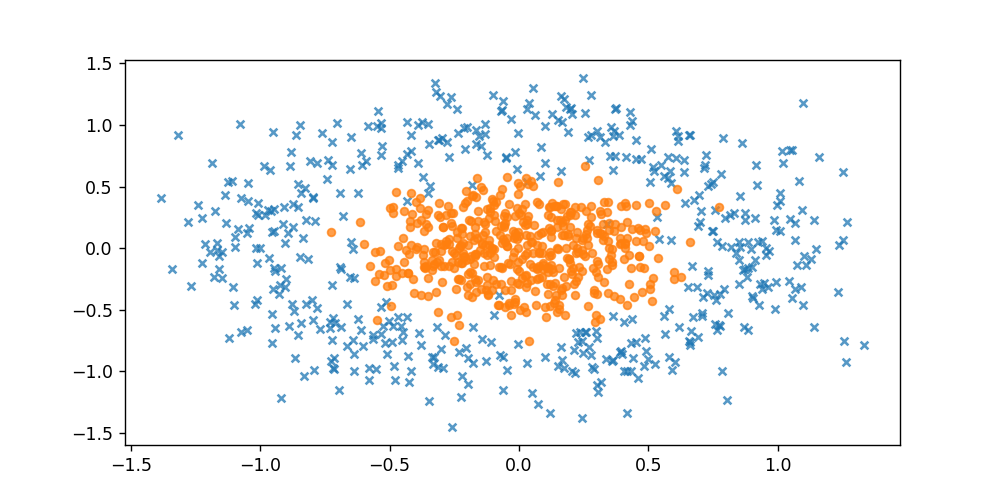

In [13]:
import sklearn.datasets
data, labels = sklearn.datasets.make_circles(n_samples=1000, noise=0.2, factor=0.25)
#data, labels = sklearn.datasets.make_moons(n_samples=1000, noise=0.2)
#data, labels = sklearn.datasets.make_blobs(n_samples=[250]*4, n_features=2, cluster_std=0.5,
#                                          centers=np.array([[-1, 1], [1, 1], [-1, -1], [1, -1]]))
#labels[labels==2] = 1; labels[labels==3] = 0;

fig, ax = plt.subplots(figsize=(8, 4))
for k, marker in enumerate(['x', 'o']):
    ax.scatter(data[labels==k, 0], data[labels==k, 1], s=20, marker=marker, alpha=0.75)
    
# Para las gráficas
x_min, x_max = data[:, 0].min() - 0.5, data[:, 0].max() + 0.5
y_min, y_max = data[:, 1].min() - 0.5, data[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

1. Antes de empezar el entrenamiento convertimos los datos a formato tensor de PyTorch
1. Luego presentamos los datos en *mini-batches* a la red neuronal en cada época del entrenamiento

PyTorch provee las clases `DataSet` y `DataLoader` para lograr estos objetivos

Estas clases son parte del módulo data: https://pytorch.org/docs/stable/data.html

En este caso crearemos un set a partir de tensores usando una clase que hereda de `DataSet`

    TensorDataset(*tensors)
    
Luego crearemos conjuntos de entrenamiento y validación usando 

    Subset(dataset, indices)
    
Finalmente crearemos dataloaders usando

    DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)



In [14]:
import sklearn.model_selection
# Separamos el data set en entrenamiento y validación
train_idx, valid_idx = next(sklearn.model_selection.ShuffleSplit(train_size=0.6).split(data, labels))


# Crear conjuntos de entrenamiento y prueba
from torch.utils.data import DataLoader, TensorDataset, Subset 

# Creamos un conjunto de datos en formato tensor
torch_set = TensorDataset(torch.from_numpy(data.astype('float32')), 
                          torch.from_numpy(labels.astype('float32')))

# Data loader de entrenamiento
torch_train_loader = DataLoader(Subset(torch_set, train_idx), shuffle=True, batch_size=32)
# Data loader de validación
torch_valid_loader = DataLoader(Subset(torch_set, valid_idx), shuffle=False, batch_size=256)

Los `DataLoader` se ocupan como iteradores de Python

In [15]:
for sample_data, sample_label in torch_train_loader:
    display(sample_data.shape)
    display(sample_label.shape)
    display(sample_label)
    break

torch.Size([32, 2])

torch.Size([32])

tensor([0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0.])

#### Recordemos

Para cada dato de entrenamiento:
- Calculamos gradientes: `loss.backward`
- Actualizamos parámetros `optimizer.step`

Para cada dato de validación
- Evaluamos la *loss* para detectar sobre-ajuste

> Una pasada por todos los datos se llama: época

#### ¿Cuándo nos detenemos?

Lo ideal es detener el entrenamiento cuando la loss de validación no haya disminuido durante una cierta cantidad de épocas

Podemos usar [`save`](https://pytorch.org/tutorials/beginner/saving_loading_models.html) para ir guardando los parámetros del mejor modelo de validación

Usamos un número fijo de épocas como resguardo: Si el modelo no ha convergido entonces debemos incrementarlo

#### ¿Cómo afecta el resultado el número de neuronas en la capa oculta?

In [ ]:
model = MLP(hidden_dim=3)
criterion = torch.nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
n_epochs = 200
running_loss = np.zeros(shape=(n_epochs, 2))

best_valid = np.inf

In [ ]:
def train_one_epoch(k, model, criterion, optimizer):
    global best_valid
    train_loss, valid_loss = 0.0, 0.0
    
    # Loop de entrenamiento
    for sample_data, sample_label in torch_train_loader:
        output = model.forward(sample_data)
        optimizer.zero_grad()        
        loss = criterion(output, sample_label.unsqueeze(1))  
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    # Loop de validación
    for sample_data, sample_label in torch_valid_loader:
        output = model.forward(sample_data)
        loss = criterion(output, sample_label.unsqueeze(1))  
        valid_loss += loss.item()
        
    # Guardar modelo si es el mejor hasta ahora
    if k % 10 == 0:
        if valid_loss < best_valid:
            best_valid = valid_loss
            torch.save({'epoca': k,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': valid_loss}, '/home/phuijse/modelos/best_model.pt')
    
    return train_loss/torch_train_loader.dataset.__len__(), valid_loss/torch_valid_loader.dataset.__len__()

In [ ]:
def update_plot(k):
    global model, running_loss
    [ax_.cla() for ax_ in ax]
    running_loss[k, 0], running_loss[k, 1] = train_one_epoch(k, model, criterion, optimizer)
    Z = model.forward(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32')))
    Z = Z.detach().numpy().reshape(xx.shape)
    ax[0].contourf(xx, yy, Z, cmap=plt.cm.RdBu_r, alpha=1., vmin=0, vmax=1)
    for i, (marker, name) in enumerate(zip(['o', 'x'], ['Train', 'Test'])):
        ax[0].scatter(data[labels==i, 0], data[labels==i, 1], color='k', s=10, marker=marker, alpha=0.5)
        ax[1].plot(np.arange(0, k+1, step=1), running_loss[:k+1, i], '-', label=name+" cost")
    plt.legend(); ax[1].grid()

fig, ax = plt.subplots(1, 2, figsize=(8, 3.5), tight_layout=True)
update_plot(0)
anim = animation.FuncAnimation(fig, update_plot, frames=n_epochs, 
                               interval=10, repeat=False, blit=False)

Neuronas de capa oculta:

In [ ]:
fig, ax = plt.subplots(1, model.hidden.out_features, figsize=(8, 3), tight_layout=True)

Z = model.hidden(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32'))).detach().numpy()
Z = 1/(1+np.exp(-Z))
for i in range(model.hidden.out_features):
    ax[i].contourf(xx, yy, Z[:, i].reshape(xx.shape), 
                   cmap=plt.cm.RdBu_r, alpha=1., vmin=np.amin(Z), vmax=np.amax(Z))

#### Recuperando el mejor modelo

In [ ]:
model = MLP(hidden_dim=3)

print("state_dict del módelo:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    print(param_tensor, "\t", model.state_dict()[param_tensor])


    
model.load_state_dict(torch.load('/home/phuijse/modelos/best_model.pt')['model_state_dict'])

print(" ")
print("state_dict del módelo recuperado:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    print(param_tensor, "\t", model.state_dict()[param_tensor])



## Diagnósticos a partir de curvas de aprendizaje

Podemos diagnosticar el entrenamiento observando la evolución de la loss 

Siempre visualiza la loss en ambos conjuntos: entrenamiento y validación

Algunos ejemplos

#### Ambas curvas en descenso

- Entrena por más épocas

In [ ]:
epochs = np.arange(1, 500)
loss_train = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs))
loss_valid = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs)) + 0.1
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
ax.set_ylim([0.5, 1.05])
plt.legend();

#### Muy poca diferencia entre error de entrenamiento y validación

- Entrena por más épocas
- Usa un modelo más complejo

In [ ]:
epochs = np.arange(1, 500)
loss_train = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs))
loss_valid = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs)) + 0.01
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
ax.set_ylim([0.5, 1.05])
plt.legend();

#### Sobreajuste temprano

- Usa un modelo más sencillo
- Usa más datos (aumentación)
- Usa regularización (dropout, L2)

In [ ]:
epochs = np.arange(1, 500)
loss_train = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs))
loss_valid = (epochs)**(-1/10) + 0.00001*(epochs)**2 +0.01*np.random.randn(len(epochs)) + 0.01
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
ax.set_ylim([0.5, 1.05])
plt.legend();

#### Error en el código o mal punto de partida

- Revisa que tu código no tenga bugs
    - Función de costo
    - Optimizador
- Mala inicialización, reinicia el entrenamiento

In [ ]:
epochs = np.arange(1, 500)
loss_train = 1.0 + 0.01*np.random.randn(len(epochs))
loss_valid = 1.0 + 0.01*np.random.randn(len(epochs)) + 0.01
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
#ax.set_ylim([0.5, 1.05])
plt.legend();